# Calculate Standard Times

# Outline

I have collected a body of wintimes from 2000-2015 (about 170,000 races). I have attempted to run various analyses on them in the previous notebooks:  

+ Calculate Standard Times
+ Calculate Standard Times Part Two
+ Calculate Wintime Coefficients  

This notebook is the authoritative and most recent attempt at calculating a body of Standard Times.

In [85]:
# set up, imports and configuration
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
# plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

## Get the Data

In [86]:
# Read wintimes from csv file
wintimes = pd.read_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/wintimes.csv")
len(wintimes)

170727

## Clean the Data

In [87]:
wintimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170727 entries, 0 to 170726
Data columns (total 11 columns):
Unnamed: 0    170727 non-null int64
raceID        170727 non-null float64
racedate      170727 non-null object
racecourse    170727 non-null float64
distance      170727 non-null float64
going         170727 non-null object
raceclass     136046 non-null float64
racetype      170727 non-null object
racetype2     170727 non-null object
age_cond      170727 non-null object
wintime       170581 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 14.3+ MB


In [88]:
# drop nas from wintimes
wintimes = wintimes.dropna(subset=['wintime'], how='any')

In [89]:
# convert going to a numbered dict
goingDict = {'firm': 1, 'fast': 2, 'good-firm': 3, 'good': 4, 'standard': 5, 'good-soft': 6, 'soft': 7, 'slow': 8, 'heavy': 9}
wintimes = wintimes.replace({"going": goingDict})

In [90]:
# convert racetype2 to a numbered dict
wintimes.racetype2.value_counts()
type2dict = {'Flat': 1, 'Hurdle': 2, 'Chase' : 3, 'National Hunt Flat' : 4}
wintimes = wintimes.replace({"racetype2": type2dict})

In [91]:
# reduce number of age_conditions categories
age_cond_dict = {'9yo+': 'N/A', '2yo+': 'N/A', '0yo+': 'N/A', '7yo+' : 'N/A', '8yo' : 'N/A', '8yo+': 'N/A',
                '4yo': '4yo+', '6yo+': '4yo+', '5yo': '4yo+', '5yo+': '4yo+', '6yo': '4yo+'}
wintimes = wintimes.replace({"age_cond": age_cond_dict})
wintimes = wintimes.drop(wintimes[wintimes.age_cond=='N/A'].index)
# convert age conditions to a numbered dict
age_cond_dict = {'2yo': 1, '3yo': 2, '4yo+' : 3, '3yo+': 4}
wintimes = wintimes.replace({"age_cond": age_cond_dict})
wintimes.age_cond.value_counts()

3    88612
4    39573
2    22636
1    19629
Name: age_cond, dtype: int64

In [92]:
# Fairly simple to convert the race dates to pandas datetime format 
wintimes['racedate'] = pd.to_datetime(wintimes['racedate'])

In [93]:
# Drop some columns and rename racetype2 to racetype
wintimes.drop(['raceID','racetype','Unnamed: 0'], axis=1, inplace=True)
wintimes.rename(columns={'racetype2':'racetype'}, inplace=True)

In [94]:
wintimes.head()

,racedate,racecourse,distance,going,raceclass,racetype,age_cond,wintime
0,2000-01-15,1.0,20.0,6,3.0,2,3,324.91
1,2000-01-15,1.0,19.5,6,2.0,3,3,309.59
2,2000-01-15,1.0,16.0,6,1.0,3,3,244.63
3,2000-01-15,1.0,16.5,6,2.0,2,3,255.31
4,2000-01-15,1.0,24.5,6,2.0,3,3,398.33


## Remove Outliers

My useful remove outliers method from part one.


In [95]:
# er... I'm not really sure how this fantastic code I wrote previously really works
# but anyway... it removes 2000 odd outlier races from 135,000 races
# I'll go with it
statsdf = wintimes.groupby(['racecourse','racetype','distance']).wintime.agg(['mean', 'std','count']).reset_index()
wintimes = pd.merge(wintimes, statsdf, how='left', on=['racecourse','racetype','distance'])
wintimes = wintimes.dropna(subset=['mean', 'std', 'wintime', 'count'], how='any')
wintimes['stdx3'] = wintimes['std'] * 3
wintimes['windiff'] = abs(wintimes['wintime'] - wintimes['mean'])
wintimes = wintimes[wintimes.windiff < wintimes.stdx3]
wintimes.drop(['windiff','stdx3','mean','std'], axis=1, inplace=True)
wintimes = wintimes[(wintimes['count'] > 5)]

## Visualise the Data

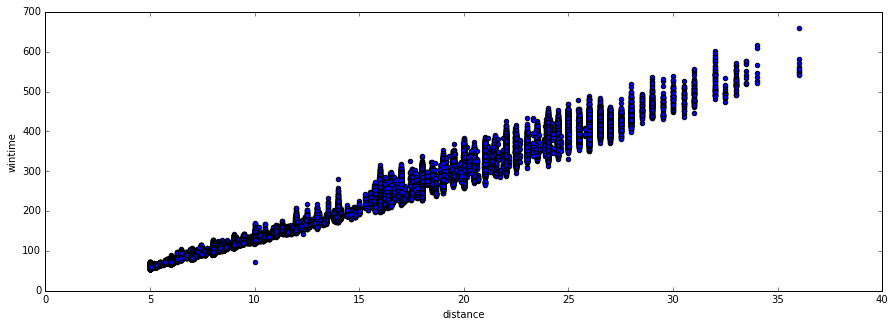

In [96]:
wintimes.plot(kind='scatter', x='distance', y='wintime')

In [97]:
wintimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167870 entries, 0 to 170449
Data columns (total 9 columns):
racedate      167870 non-null datetime64[ns]
racecourse    167870 non-null float64
distance      167870 non-null float64
going         167870 non-null int64
raceclass     133857 non-null float64
racetype      167870 non-null int64
age_cond      167870 non-null int64
wintime       167870 non-null float64
count         167870 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 12.8 MB


In [98]:
len(wintimes)

167870

In [99]:
wintimes.going.value_counts()

4    34770
3    34231
6    26129
5    22611
7    22082
9    13608
1     7291
2     5629
8     1519
Name: going, dtype: int64

In [100]:
wintimes.raceclass.value_counts()

5.0    39779
4.0    37955
6.0    26517
3.0    13917
2.0     7028
1.0     6459
7.0     2202
Name: raceclass, dtype: int64

In [101]:
wintimes.racetype.value_counts()
# 1: Flat, 2: Hurdle, 3: Chase, 4: NH Flat

1    96111
2    38212
3    26657
4     6890
Name: racetype, dtype: int64

In [102]:
wintimes.age_cond.value_counts()
# 1: 2yo, 2: 3yo, 3: 3yo+, 4: 4yo+

3    87114
4    39136
2    22283
1    19337
Name: age_cond, dtype: int64

In [103]:
# I'll write the clean wintimes to a new csv file 'clean_wintimes_4.csv' here
wintimes.to_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/clean_wintimes_4.csv")

## Create Standard Times

I decide to take the 5th percentile (i.e. 95% fastest time) for each racecourse, racetype and distance configuration as my standard time. 

In [104]:
std_times = wintimes.groupby(['racecourse','racetype','distance']).wintime.quantile(.05).reset_index()

In [105]:
std_times.describe()

,racecourse,racetype,distance,wintime
count,1429.000000,1429.000000,1429.000000,1429.000000
mean,89.568929,2.076277,16.430203,231.821501
std,87.103951,1.002338,6.328793,101.890623
min,1.000000,1.000000,5.000000,54.102500
25%,22.000000,1.000000,11.980000,149.377500
50%,47.000000,2.000000,16.500000,234.543500
75%,206.000000,3.000000,20.700000,304.260000
max,229.000000,4.000000,36.000000,542.583000


In [106]:
std_times.rename(columns={'wintime':'std_time'}, inplace=True)

In [107]:
# Standard Times for Ascot on the flat
std_times[(std_times.racecourse==1) & (std_times.racetype==1)]

,racecourse,racetype,distance,std_time
0,1.0,1,5.00,59.1100
1,1.0,1,6.00,72.4915
2,1.0,1,6.50,80.7430
3,1.0,1,7.00,85.9000
4,1.0,1,8.00,98.3240
5,1.0,1,10.00,123.8985
6,1.0,1,12.00,147.6680
7,1.0,1,14.00,179.9515
8,1.0,1,16.00,205.3120
9,1.0,1,16.20,209.1270


In [108]:
# I'll write the standard times to a new file 'standard_times.csv' here
std_times.to_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/standard_times.csv")

## Conclusion

I've done it before but it helps to go over it all and put all the work into one notebook. The next stage is to apply these standard times to my results dataset.

## Benjamin Woodling | 09.09.2016